In [1]:
# google colab の場合は、この下のコメントアウトを外す
# ! pip install japanize-matplotlib
# ! pip install statsmodels==0.13.1
# ! pip install pmdarima
# ! pip install pykalman

In [2]:
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
import openpyxl
import numpy as np
import statsmodels
import pmdarima
import sklearn
import pykalman

DataFrame.shape: (274, 5)
          年月  平均気温  最低気温  最高気温   降水量
0 2000-01-01   5.6  -5.4  16.3  58.0
1 2000-02-01   3.8  -5.3  13.4   2.0
2 2000-03-01   7.6  -5.0  19.5  88.0
            年月  平均気温  最低気温  最高気温    降水量
271 2022-08-01  27.5  18.9  38.3   88.0
272 2022-09-01  24.3  16.6  33.1  231.0
273 2022-10-01  16.5   5.4  30.4  108.0


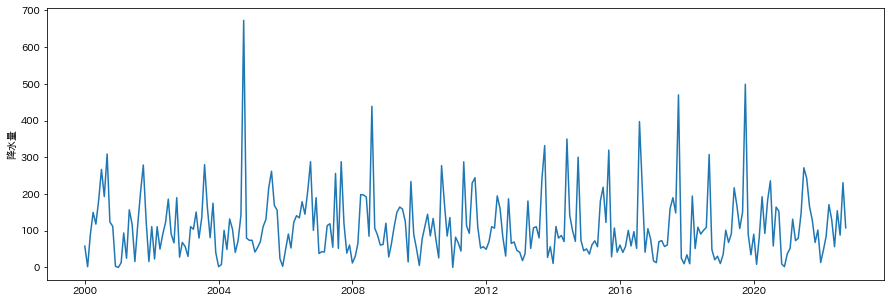

In [3]:
# さいたま市の気象データのデータフレームを作成
url = 'https://github.com/KHiraGit/sudspg_ds/raw/main/ml08_saitama_monthly_weather_data.xlsx'
data_df = pd.read_excel(url)
print('DataFrame.shape:', data_df.shape) # データフレームの形状を表示
print(data_df.head(3))  # 先頭3行を表示
print(data_df.tail(3))  # 先頭3行を表示
x_label = '年月'
y_label = '降水量'

fig, ax = plt.subplots(1, 1, figsize=(15,5)) # 折れ線グラフで表示
ax.set_ylabel(y_label)
g = ax.plot(data_df[x_label], data_df[y_label])

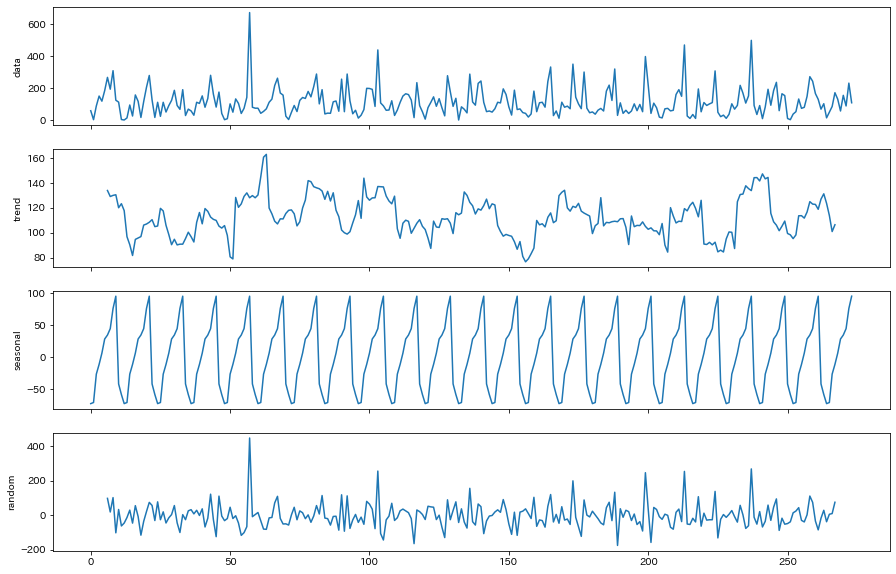

In [4]:
# 時系列データの成分分解（data -> tread, seasonal, random）
data = data_df[y_label].values
pmdarima.utils.decomposed_plot(pmdarima.arima.decompose(data,'additive',m=12),
                               figure_kwargs = {'figsize': (15, 10)} )

            年月  平均気温  最低気温  最高気温  降水量
250 2020-11-01  12.8   1.8  25.0  9.5
251 2020-12-01   6.3  -4.6  16.8  2.0
            年月  平均気温  最低気温  最高気温   降水量
252 2021-01-01   4.0  -7.0  17.2  37.0
253 2021-02-01   6.9  -3.3  21.9  52.0


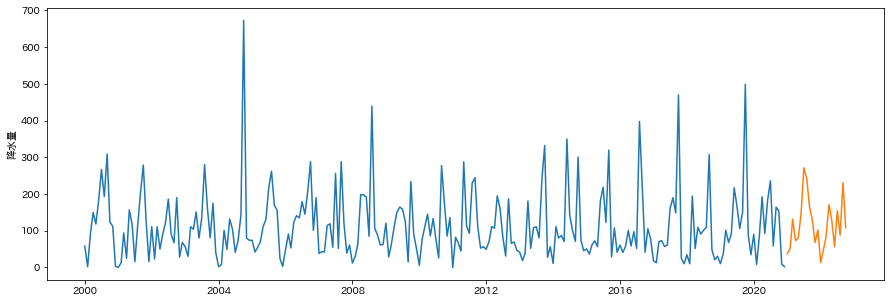

In [5]:
# 時系列モデルの学習と性能検証のため、データを学習用(先頭から270件)と検証用(271件目以降)に分割
train_data = data_df[:252]
print(train_data.tail(2))
test_data = data_df[252:]
print(test_data.head(2))
fig, ax = plt.subplots(1, 1, figsize=(15,5)) # 折れ線グラフで表示
g = ax.set_ylabel(y_label)
g = ax.plot(train_data[x_label], train_data[y_label])
g = ax.plot(test_data[x_label], test_data[y_label])

In [6]:
# 単位根検定 -> 先頭から、検定値、P値 の順で出力される (P値が 0.05より大きい場合、単位根AR(p)過程でないとはいえない)
print(statsmodels.tsa.stattools.adfuller(train_data[y_label].values))

(-6.758949129951259, 2.8243409807328767e-09, 10, 241, {'1%': -3.4577787098622674, '5%': -2.873608704758507, '10%': -2.573201765981991}, 2775.361855636463)


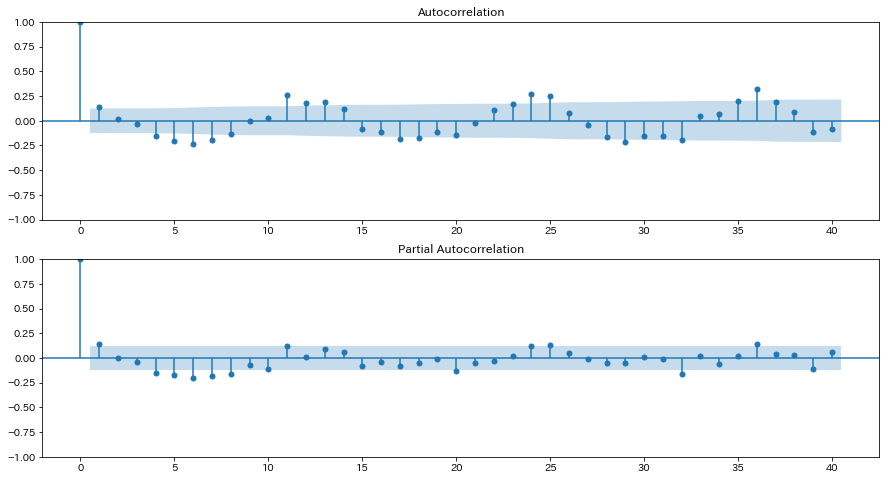

In [7]:
# コレログラム（自己相関と偏自己相関）を表示
data = train_data[y_label].values
fig, ax = plt.subplots(2, 1, figsize=(15,8))
fig = statsmodels.api.graphics.tsa.plot_acf(data, lags=40, ax=ax[0])
fig = statsmodels.api.graphics.tsa.plot_pacf(data, lags=40, ax=ax[1], method='ywm')

 ARIMA(1,0,0)(1,0,1)[12] intercept
train_data MAE: 56.7441537006431
train_data MSE: 6751.886169776368
test_data MAE: 42.236693939447534
test_data MSE: 3040.271066416229


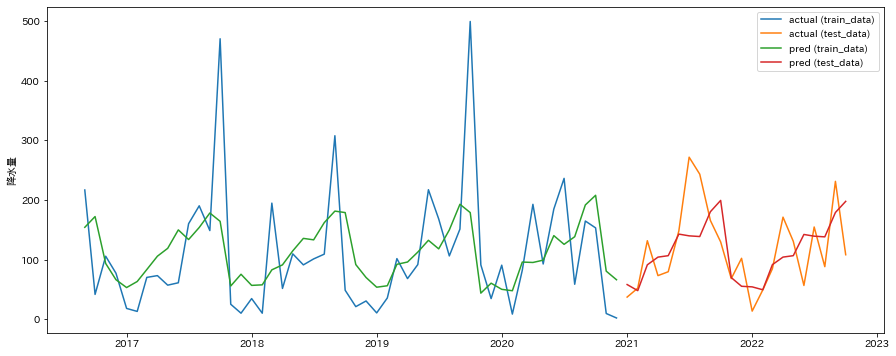

In [13]:
# 次数探索を行い、最適次数でモデルを作成し、学習データで学習
auto_model = pmdarima.auto_arima(train_data[y_label].values, seasonal=True, m=12)
print(auto_model)

##学習データの期間の予測値と、その平均絶対誤差(MAE)と平均二乗誤差(MSE)
train_pred = auto_model.predict_in_sample()
print('train_data MAE:', 
      sklearn.metrics.mean_absolute_error(train_data[y_label].values, train_pred))
print('train_data MSE:', 
      sklearn.metrics.mean_squared_error(train_data[y_label].values, train_pred))
##テストデータの期間の予測値と予測区間(95%信頼区間)と、その平均絶対誤差(MAE)と平均二乗誤差(MSE)
test_pred, test_pred_ci = auto_model.predict(n_periods=test_data.shape[0], return_conf_int=True)
print('test_data MAE:', 
      sklearn.metrics.mean_absolute_error(test_data[y_label].values, test_pred))
print('test_data MSE:', 
      sklearn.metrics.mean_squared_error(test_data[y_label].values, test_pred))

# 観測値と予測値をグラフで表示 (見やすくするために、2016年7月以降を表示)
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax.set_ylabel(y_label)
g = ax.plot(train_data[200:][x_label], train_data[200:][y_label], label="actual (train_data)")
g = ax.plot(test_data[x_label], test_data[y_label], label="actual (test_data)")
g = ax.plot(train_data[200:][x_label], train_pred[200:], label="pred (train_data)")
g = ax.plot(test_data[x_label], test_pred, label="pred (test_data)")
# ax.fill_between(test_data[x_label], test_pred_ci[:, 0], test_pred_ci[:, 1], color='c', alpha=.2)
g = ax.legend()

In [9]:
# 推移行列などの初期化
## 島田直樹、時系列解析(共立出版)のサンプルコートから引用
def FGHset(n_dim_trend, n_dim_obs=1, n_dim_series=0, Q_sigma2=10):
    n_dim_Q = (n_dim_trend!=0) + (n_dim_series!=0)
    if n_dim_series>0:
        n_dim_state = n_dim_trend + n_dim_series - 1
    else:
        n_dim_state = n_dim_trend
    
    # 行列の初期化
    G = np.zeros((n_dim_state, n_dim_Q))
    F = np.zeros((n_dim_state, n_dim_state))
    H = np.zeros((n_dim_obs, n_dim_state))
    Q = np.eye(n_dim_Q) * Q_sigma2
    
    ## トレンドモデルのブロック行列の構築
    G[0,0] = 1
    H[0,0] = 1
    if n_dim_trend==1: 
        F[0,0] = 1
    elif n_dim_trend==2:
        F[0,0] = 2
        F[0,1] = -1
        F[1,0] = 1
    elif n_dim_trend==3:
        F[0,0] = 3
        F[0,1] = -3
        F[0,2] = 1
        F[1,0] = 1
        F[2,1] = 1
        
    start_elem = n_dim_trend
    start_col = n_dim_trend
    # 季節調整成分のブロック行列の構築
    if n_dim_series>0:
        G[start_elem, 1] = 1
        H[0, start_elem] = 1
        for i in range(n_dim_series-1): 
            F[start_elem, start_elem+i] = -1
        for i in range(n_dim_series-2): 
            F[start_elem+i+1, start_elem+i] = 1
    
    # PyKalmanのQはG.dot(Q).dot(G.T)を想定しているためQをupdate
    Q = G.dot(Q).dot(G.T)
    
    return n_dim_state, F, H, Q

train_data MAE: 3.204721971179177
train_data MAE: 21.081358676770254
test_data MAE: 39.12838826797003
test_data MAE: 2766.0550084534225


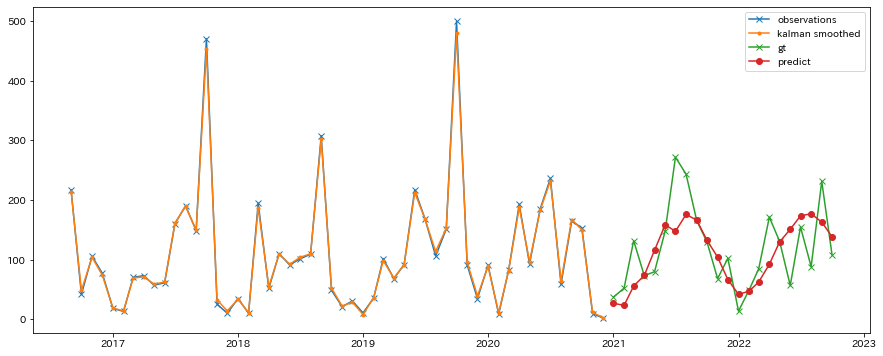

In [14]:
# プログラムを見やすくするために観測値の変数を用意
observations = train_data[y_label].values

# カルマンフィルタを作成
n_dim_state, F, H, Q = FGHset(2,1,12) # ハイパーパラメータを準備 (トレンドの次元数、観測値の次元数、季節成分の次元数)
kf = pykalman.KalmanFilter(transition_matrices=F,  # 状態の推移行列
                           transition_covariance=Q,  # 状態ノイズの分散共分散行列
                           observation_matrices=H)  # 観測値の行列
emed_kf = kf.em(observations, n_iter=10, em_vars='all')  # ハイパーパラメータを更新
smoothed_state_means, smoothed_state_covs = emed_kf.smooth(observations) # フィルタリング+平滑化
train_pred = smoothed_state_means.dot(H.T)

# カルマンフィルタで予測
test_pred = np.empty(len(test_data)) # 予測値を格納するベクトルを用意
current_state = smoothed_state_means[-1]
current_cov = smoothed_state_covs[-1]
for i in range(len(test_data)):
    current_state, current_conv = emed_kf.filter_update(current_state, current_cov, observation=None)
    test_pred[i] = kf.observation_matrices.dot(current_state)

## 学習用データの区間と検証用データの区間の予測値の平均絶対誤差(MAE)と平均二乗誤差(MSE)
print('train_data MAE:', sklearn.metrics.mean_absolute_error(train_data[y_label].values, train_pred))
print('train_data MAE:', sklearn.metrics.mean_squared_error(train_data[y_label].values, train_pred))
print('test_data MAE:', sklearn.metrics.mean_absolute_error(test_data[y_label].values, test_pred))
print('test_data MAE:', sklearn.metrics.mean_squared_error(test_data[y_label].values, test_pred))

# 観測値と予測値をグラフで表示 (見やすくするために、2016年7月以降を表示)
plt.figure(figsize=(15, 6))
plt.plot(train_data[200:][x_label], observations[200:], marker='x', label="observations")
plt.plot(train_data[200:][x_label], train_pred[200:], marker='.', label="kalman smoothed")
plt.plot(test_data[x_label], test_data[y_label], marker='x', label="gt")
plt.plot(test_data[x_label], test_pred, marker='o', label="predict")
plt.legend()
plt.show()